In [29]:
import torchvision
import matplotlib.pyplot as plt
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from avalanche.training.supervised import Naive
from avalanche.models import SlimResNet18
from avalanche.benchmarks import with_task_labels, benchmark_from_datasets
from utils import load_CLEAR, build_CLEAR_experiences
from avalanche.logging import InteractiveLogger, TextLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.evaluation.metrics import forgetting_metrics, \
accuracy_metrics, loss_metrics, timing_metrics, confusion_matrix_metrics

In [30]:
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
train_transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((32, 32)),
            #normalize,
        ]
    )
folder_path = '/Users/marcodamommio/2023-2024_OCL_Class-Incremental/train/labeled_images'
images_dict = load_CLEAR(folder_path, transform=train_transform)

libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


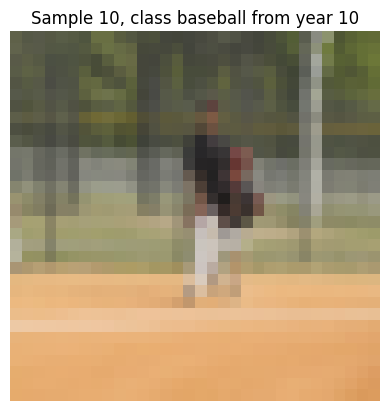

In [31]:
year_folder_name = '10'
class_folder_name = 'baseball'
images_array = images_dict[year_folder_name][class_folder_name]

elem = 10
plt.imshow(images_array[elem].permute(1,2,0))
plt.axis('off')  # Nascondere gli assi
plt.title(f'Sample {elem}, class {class_folder_name} from year {year_folder_name}')
plt.show()

In [32]:
classes_pair = [
    ('BACKGROUND', 'baseball'),
    ('bus', 'camera'),
    ('cosplay', 'dress'),
    ('hockey', 'laptop'),
    ('racing', 'soccer'),
    ('sweater', None)   
]

In [33]:
experiences = build_CLEAR_experiences(images_dict, classes_pair)

In [34]:
bm = with_task_labels(benchmark_from_datasets(train=experiences))
bm

In [35]:
model = SlimResNet18(nclasses=11, nf=5)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = CrossEntropyLoss()
loggers = [InteractiveLogger(), TextLogger(open('log.txt', 'a'))]
eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    forgetting_metrics(experience=True, stream=True),
    confusion_matrix_metrics(num_classes=11, save_image=False,
                             stream=True),
    loggers=loggers
)
cl_strategy = Naive(
    model=model, 
    optimizer=optimizer, 
    criterion=criterion,
    train_mb_size=10,
    train_epochs=1, 
    eval_mb_size=100,
    evaluator=eval_plugin
)

In [26]:
# TRAINING LOOP
print('Starting experiment...')
results = []
for experience in bm.train_stream[:10]:
    print("Start of experience: ", experience.current_experience)

    # in Avalanche an experience may have multiple task labels
    # if the samples in its dataset come from different tasks
    # here we just have one task label per experience
    print(f"\tTask labels: {experience.task_labels}")

    cl_strategy.train(experience)
    print('Training completed')

Starting experiment...
Start of experience:  0
	Task labels: {0}
-- >> Start of training phase << --
100%|██████████| 1/1 [00:00<00:00, 37.66it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.6732
	Loss_MB/train_phase/train_stream/Task000 = 2.6732
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0268
	Time_Epoch/train_phase/train_stream/Task000 = 0.0268
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_MB/train_phase/train_stream/Task000 = 0.0000
-- >> End of training phase << --
Training completed
Start of experience:  1
	Task labels: {0}
-- >> Start of training phase << --
100%|██████████| 1/1 [00:00<00:00, 68.72it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 2.6638
	Loss_MB/train_phase/train_stream/Task000 = 2.6638
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0143
	Time_Epoch/train_phase/train_stream/Task000 = 0.0143
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.0000
	Top1_Acc_MB/train_phase/train_stre